# Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
def my_convolve(img, filter):
    rows, cols = img.shape
    convolved_img = np.zeros((rows - filter.shape[0] + 1, cols - filter.shape[1] + 1))
    for row in range(convolved_img.shape[0]):
        for col in range(convolved_img.shape[1]):
            convolved_img[row, col] = np.sum(np.multiply(img[row:row+filter.shape[0], col:col + filter.shape[1]], filter))

    return convolved_img

In [3]:
def image_hist(image, save = False, fname = ""):
    if len(image.shape) == 3:
        # calculate mean value from RGB channels and flatten to 1D array
        vals = image.flatten()
    else : 
        vals = image.flatten()


    fig, ax = plt.subplots(figsize=(20,10))
    ax1 = fig.add_subplot(121)
    ax1.set_xlim([-5, 300])
    ax1.hist(vals, bins=range(256))


    ax2 = fig.add_subplot(122)
    ax2.imshow(image, cmap='gray', vmin=0, vmax=255)  
    ax2.axis('off')

    ax.axis('off')
    if save: plt.savefig(fname)
    plt.show()

In [4]:
def draw_mask(circles, image):
    image_copy = image.copy()
    # Print the output
    (x , y, r, v) = circles[0]
    (x1 , y1, r1, v1) = circles[1]

    cv2.circle(image_copy, (int(y) , int(x)), int(r), (255,0,0), 2)
    cv2.circle(image_copy, (int(y) , int(x)), int(r1), (255,0,0), 2)

    gray_copy = gray.copy()
    cv2.circle(gray_copy, (int(y) * 5 , int(x) * 5), int(r) * 5, (255,0,0), 2)
    cv2.circle(gray_copy, (int(y) *5 , int(x) * 5  ), int(r1) * 5, (255,0,0), 2)

    gray_copy1 = img.copy()
    # draw masks
    mask1 = np.zeros_like(gray_copy1)
    mask1 = cv2.circle(mask1, (int(circles[0][1] * 5), int(circles[0][0])* 5), int(circles[0][2])* 5, (255,255,255), -1)
    mask2 = np.zeros_like(gray_copy1)
    mask2 = cv2.circle(mask2, (int(circles[0][1]* 5), int(circles[0][0])* 5), int(circles[1][2])* 5, (255,255,255), -1)
    mask = cv2.subtract(mask2, mask1)
    masked_resized = cv2.bitwise_and(gray_copy1,mask)
    return masked_resized, gray_copy

# Edge Detection implementation

In [5]:
def resize(img, percent):
    print('image.shape : {}'.format(img.shape))
    width = int(img.shape[1] * percent / 100)
    height = int(img.shape[0] * percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    strongest_i,strongest_j = np.where(resized >= 200) 
    resized[strongest_i, strongest_j] = 0
    
    print("resized.shape : {}".format(resized.shape))
    return resized

def sobel_filters(img):
  edge_threshold = 7
  Hx = np.array([[1, 0, -1], [edge_threshold, 0, -edge_threshold], [1, 0, -1]])
  Hy = np.array([[1, edge_threshold, 1], [0, 0, 0], [-1, -edge_threshold, -1]])

  Gx = my_convolve(img, Hx)
  Gy = my_convolve(img, Hy)
  G = np.sqrt(np.power(Gx, 2) + np.power(Gy, 2))

  strongest_i,strongest_j = np.where(G >= 200) 
  G[strongest_i, strongest_j] = 0

  theta = np.arctan2(Gy, Gx)
  return (G, theta)

def non_max_suppression(img, D):
    rows = img.shape[0]
    cols = img.shape[1]
    non_max = np.zeros((rows,cols), dtype=np.int32)
    angle = D * 180. / np.pi
    for i in range(2, rows - 2):
        for j in range(2, cols - 2):
            try:
                q = []
                if ((angle[i,j] < 22.5) and (-22.5 <= angle[i,j])) or ((angle[i,j] < -157.5) and (157.5 <= angle[i,j]))  :  # horizental
                    q = [img[i, j+1], img[i, j+2] , img[i-1, j+2], img[i+1, j+2], img[i, j-1], img[i, j-2] , img[i-1, j-2], img[i+1, j-2]]
                elif ((angle[i,j] < 67.5) and (22.5 <= angle[i,j])) or ((angle[i,j] < -112.5) and (-157.5 <= angle[i,j]))  :  # 45degree
                    q = [img[i - 1, j + 1], img[i - 1 , j+2] , img[i-2, j+1], img[i-2, j+2], img[i+1, j-1], img[i+1, j-2] , img[i+2, j-1], img[i+2, j-2]]
                elif ((angle[i,j] < 112.5) and (67.5 <= angle[i,j])) or ((angle[i,j] < -67.5) and (-112.5 <= angle[i,j]))  :  # vertical
                    q = [img[i - 1, j], img[i - 2, j] , img[i-2, j+1], img[i-2, j-1], img[i+1, j], img[i+2, j] , img[i+2, j+1], img[i+2, j-1]]
                else: # 135degree
                    q = [img[i + 1, j + 1], img[i + 1 , j+2] , img[i+2, j+1], img[i+2, j+2], img[i-1, j-1], img[i-1, j-2] , img[i-2, j-1], img[i-2, j-2]]
                q.sort()
                if (img[i,j] >= q[-3]):
                    non_max[i,j] = img[i,j]
                else:
                    non_max[i,j] = 0
            except IndexError as e:
                pass
    return non_max

def threshold_img(img):
    highThreshold = img.max() * 0.1
    img = img.astype('uint8')
    
    otsu_threshold_val, ret_matrix = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    lowThreshold = otsu_threshold_val
    rows, cols = img.shape
    res = np.zeros((rows, cols), dtype=np.int32)

    strong = np.int32(255)

    strongest_i,strongest_j = np.where(img == 255) 
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where((img < lowThreshold)  )
    mid_i, mid_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[ mid_i, mid_j] = 0
    res[ zeros_i, zeros_j] = 0
    res[strongest_i, strongest_j] = 0
    return (res)
    
def hysteresis(img):
    rows, cols = img.shape

    pixel_threshold = 2
    
    weak = np.int32(75)
    strong = np.int32(255)

    for i in range(1, rows - pixel_threshold -1):
        for j in range(1, cols - pixel_threshold - 1):
            if (img[i,j] == weak):
                for k in range(-pixel_threshold, pixel_threshold+1):
                    for q in range(-pixel_threshold, pixel_threshold+1):
                        if img[i+k, j+q] == strong:
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
    return img

# Run Edge Detection

image.shape : (576, 768)
resized.shape : (115, 153)


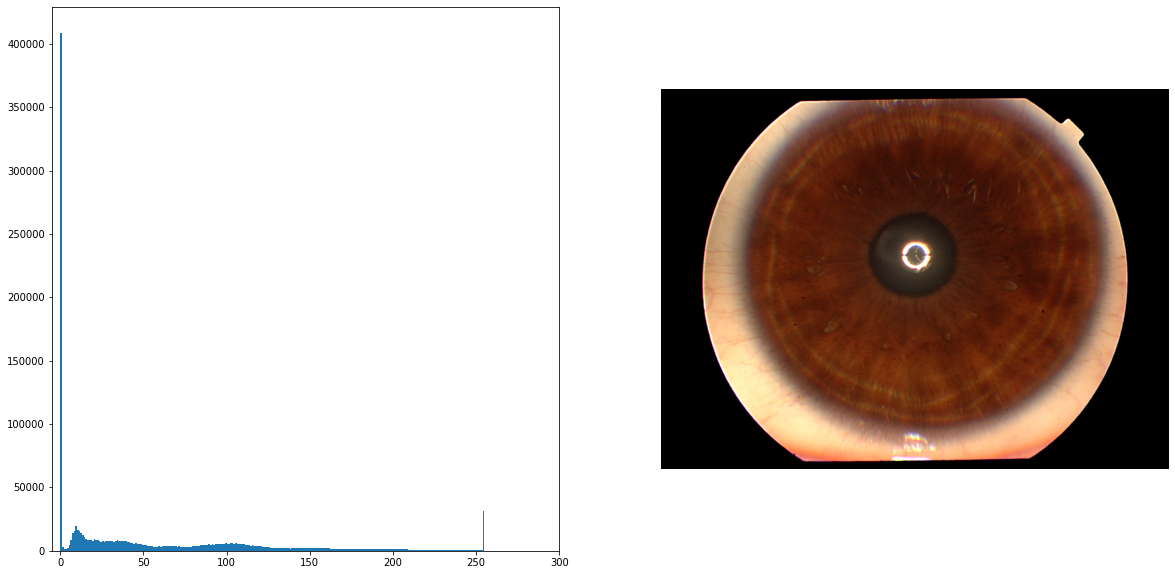

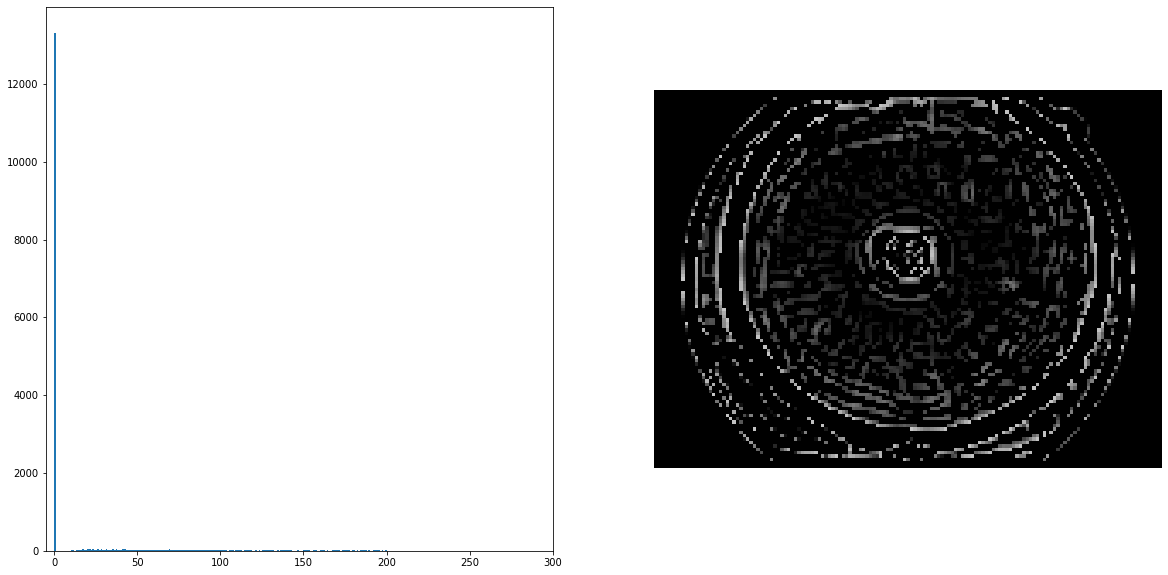

In [6]:
image_path ='001L_3.png'
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray =  cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

resized = resize(gray, 20)
blur = (1 / 16.0) * np.array([[1., 2., 1.],
                                 [2., 4., 2.],
                                 [1., 2., 1.]])

blurred = my_convolve(resized, blur)
sobel = sobel_filters(blurred)
non_max = non_max_suppression(sobel[0], sobel[1])
threshold = threshold_img(non_max)
edges = hysteresis(threshold)
image_hist(img)
image_hist(non_max)

# Hough implementation


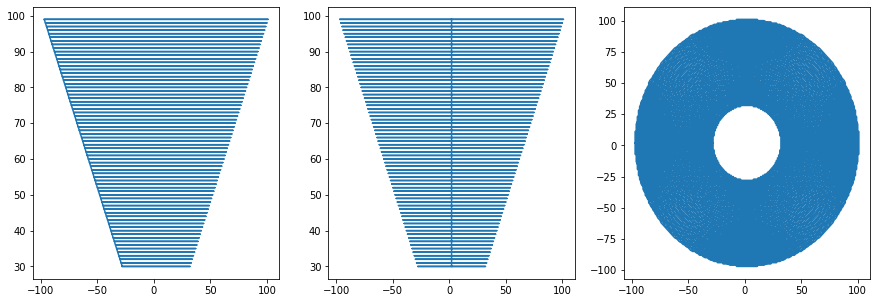

In [7]:
def calc_cos_sin(angles, r_range=[30, 100]):
    _sin = np.sin(angles * np.pi / 180 )
    _cos = np.cos(angles * np.pi / 180 )
    # plt.plot(_sin)
    # plt.plot(_cos)
    # plt.show()
    sin_out = []
    cos_out = []
    r_out = []

    for r in range(r_range[0], r_range[1]):
        for angle in angles:
            sin_out.append((r * _sin[angle]))
            cos_out.append((r * _cos[angle]))
            r_out.append(r)
    return np.array(sin_out), np.array(cos_out), np.array(r_out)
sin_out, cos_out, r_out = calc_cos_sin(np.arange(0, 361))
sin_out.shape, cos_out.shape, r_out.shape

# Draw Functions Output
fig, ax = plt.subplots(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax1.plot(np.round(2 - cos_out), r_out)

ax2 = fig.add_subplot(132)
ax2.plot(np.round(2 - sin_out), r_out)

ax3 = fig.add_subplot(133)
ax3.plot(np.round(2 - cos_out), np.round(2 - sin_out))

ax.axis('off')
plt.show()

In [8]:
def x_y_calc(x, y, _sin, _cos, _r, x_range, y_range):
    # print(x_range, y_range)
    a = np.round(x - _cos)# x - r * cos(theta)
    b = np.round(y - _sin)# y - r * sin(theta)

    a_b = np.stack((a, b, _r), axis=-1) # a_b = [a, b, r]
    a_b = a_b[np.logical_and(np.logical_and(a_b[:,0] > x_range[0], a_b[:,0] < x_range[1]) ,np.logical_and(a_b[:,1] > y_range[0], a_b[:,1] < y_range[1]))] #filter a_b

    _a = a_b[:,0].flatten().astype('int32')
    _b = a_b[:,1].flatten().astype('int32')
    _r = a_b[:,2].flatten().astype('int32')

    np.add.at(accumulator, (_a, _b, _r), 1)
    return 0

x_y_func = np.vectorize(x_y_calc, signature='(),(),(k),(k),(k),(m),(m)->()', otypes=[np.int32])


def hough(input, threshold, r_range, x_range = [], y_range = []):

    print(input.shape)
    edges = np.where(input > 0)

    global accumulator
    accumulator = np.zeros((input.shape[0], input.shape[1], r_range[1]))
    print(edges[0].shape[0], "   ", edges[1].shape[0])

    _sin, _cos, _r = calc_cos_sin(np.arange(0, 361), r_range)

    if x_range == [] : x_range = [0, input.shape[0]]
    if y_range == [] : y_range = [0, input.shape[1]]

    _acc = x_y_func(edges[0], edges[1], _sin, _cos, _r, x_range, y_range)
    
    result = np.where(accumulator > threshold) #check threshold
    results = np.stack((result[0], result[1], result[2], accumulator[result]), axis=-1) #results = [a, b, r, vote]
    results = sorted(results, key=lambda x: -x[-1]) #sort according to votes
    return results

def last_filter(circles): 
    b, a, r, v = circles[0]
    for d, c, g, e in circles:
        if  np.abs(c + g) - np.abs(a + r) > 5 and np.abs(a - r) - np.abs(c - g) > 5 and np.abs(d + g) - np.abs(b + r) > 5 and np.abs(b - r) - np.abs(d - g) > 5 and np.abs(a - c) < 10 and np.abs(b - d) < 10 and np.abs(r - g) > 25 :
            return [(b, a, r, v)  ,(d, c, g, e)]
    for d, c, g, e in circles:
        if  np.abs(c + g) - np.abs(a + r) > 5 and np.abs(a - r) - np.abs(c - g) > 5 and np.abs(d + g) - np.abs(b + r) > 5 and np.abs(b - r) - np.abs(d - g) > 5  and np.abs(r - g) > 50 :
            return [(b, a, r, v)  ,(d, c, g, e)]


# Daugman Normalization

In [9]:
def daugman_normalizaiton(image, height, width, r_in, r_out, a, b):    

    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # width values (thetas)

    img = np.zeros((height,width, 3), np.uint8)

    for (i, theta) in enumerate(thetas):
        for j in range(height):
            for channel in range(2):
                r = j / height

                Xin = a + r_in * np.cos(theta)
                Yin = b + r_in * np.sin(theta)
                Xo = a + r_out * np.cos(theta)
                Yo = b + r_out * np.sin(theta)

                Xc = (1 - r) * Xin + r * Xo
                Yc = (1 - r) * Yin + r * Yo

                color = image[int(Xc)][int(Yc)][int(channel)]
                img[j][i][int(channel)] = color
    return img  

# Run Hough Transform

In [10]:
image_path ='001L_3.png'
image = cv2.imread(image_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray =  cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

resized = resize(gray, 20)
blur = (1 / 16.0) * np.array([[1., 2., 1.],
                                 [2., 4., 2.],
                                 [1., 2., 1.]])

blurred = my_convolve(resized, blur)
sobel = sobel_filters(blurred)
non_max = non_max_suppression(sobel[0], sobel[1])
threshold = threshold_img(non_max)
edges = hysteresis(threshold)
circles = hough(non_max, 50, r_range=[10, 60], x_range=[40, 70], y_range=[60, 90])  
filtered_circles = last_filter(circles)

masked_resized, image_circles = draw_mask(filtered_circles, resized)
image_nor = daugman_normalizaiton(masked_resized,90,360, filtered_circles[0][2] * 5, filtered_circles[1][2] * 5, filtered_circles[0][0] * 5, filtered_circles[0][1] * 5)

image.shape : (576, 768)
resized.shape : (115, 153)
(111, 149)
3227     3227


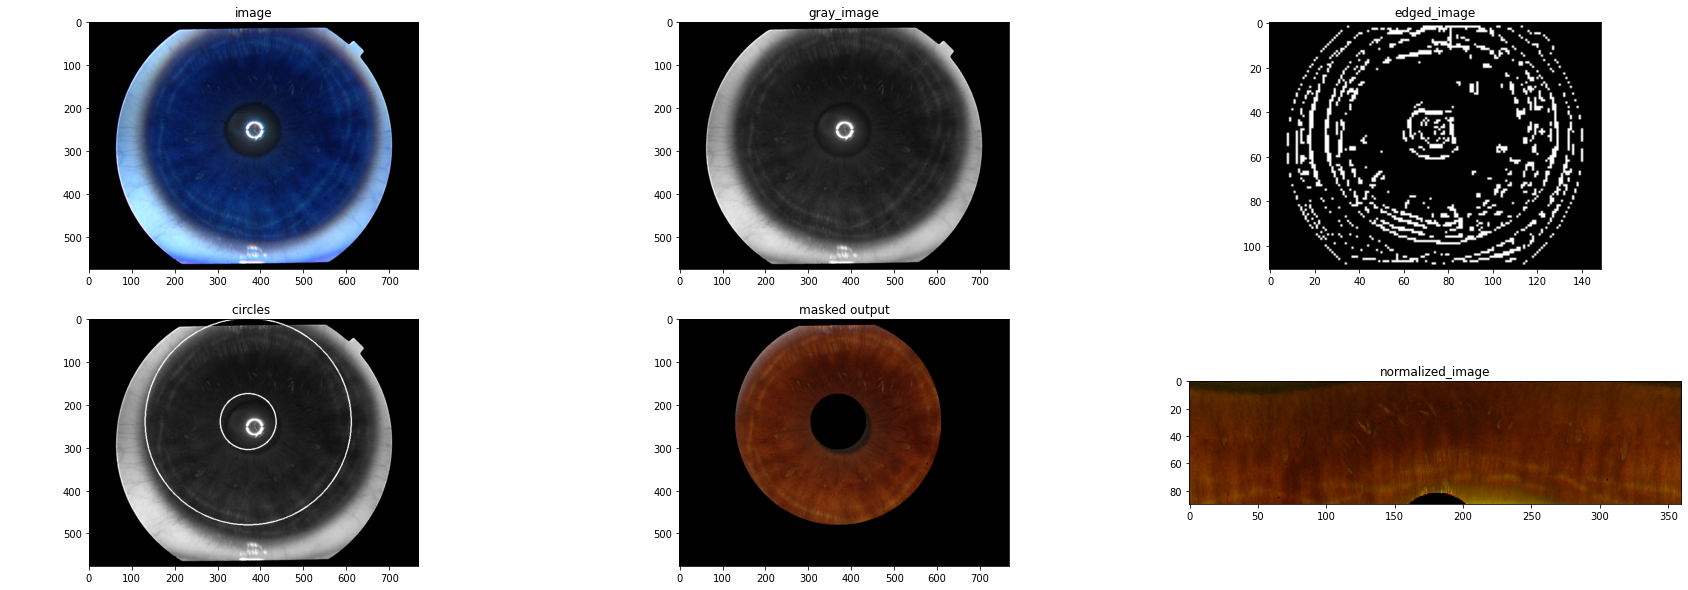

In [11]:
# Draw Outputs
fig, ax = plt.subplots(figsize=(30, 10))
ax.axis('off')
ax6 = fig.add_subplot(231)
ax6.imshow(image)
ax6.set_title("image")
ax5= fig.add_subplot(232)
ax5.imshow(gray , cmap='gray', vmin=0, vmax=255)
ax5.set_title("gray_image")
ax1= fig.add_subplot(233)
ax1.imshow(edges , cmap='gray', vmin=0, vmax=255)
ax1.set_title("edged_image")
ax2= fig.add_subplot(234)
ax2.imshow(image_circles, cmap='gray', vmin=0, vmax=255)
ax2.set_title("circles ")
ax3= fig.add_subplot(235)
ax3.imshow(masked_resized, cmap='gray', vmin=0, vmax=255)
ax3.set_title("masked output")
ax4= fig.add_subplot(236)
ax4.imshow(image_nor,  cmap='gray', vmin=0, vmax=255)
ax4.set_title("normalized_image")
plt.show()